# Парсер вакансий на HH.ru

### Step 1. You need to specify search parameters for HH API

В этой ячейке нужно указать необходимые параметры, которые будут указаны в запросе к HH.ru

In [ ]:
from google.colab import drive


# Slag позиции, будет использовать при создании директории на Google-диске, 
# если потребуется сохранить результаты парсинга на диск в xls-файле

position_title = 'ml'


# Спсиок названий позиций, по которым будет выполняться поиск на HH.ru,
# ниже показан пример для ML-инженера. Лучше указать название и на кириллице, и
# на латинице

job_titles = [
    'Разработчик Machine Learning',
    'ML Engineer'
]


# Необязательный параметр. Используется для того, чтобы вакансии с разными title's
# объединить под одним title. Пример ниже, оба названия в дальнейшей аналитике
# будут объеденены под общим title: ML

skills_synonyms = {
    'Machine Learning': 'ML',
    'Машинное обучение': 'ML'
}


# Список ID специализаций, для которых будет выполняться поиск вакансий.
# 1 указывается для 'Информационные технологии, интернет, телеком'.
# Если нужны какие-то дополнительные специализации, то нужно открыть справочник
# https://api.hh.ru/specializations, выбрать ID нужных специалиазций и указать их
# в параметре specialization_ids, например, '1', '2', '3', если специализаций несколько

specialization_ids = '1'


# Эту строчку не трогаем, просто скрипт подключается на запись к вашему Google Drive

# Connect to Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Step 2. Import libs

В этой ячейке подключаются необходимые для дальнейшей работы ббилиотеки. Ее просто нужно запустить и подождать пока все модули инициализируются.

In [ ]:
# For convert saalries in USD and EUR to RUR
!pip install forex-python

import requests
import json
import os
import time
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from forex_python.converter import CurrencyRates
from functools import lru_cache
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from datetime import datetime
from dateutil.relativedelta import relativedelta


nltk.download("stopwords")
plt.style.use('fivethirtyeight')

# HH endpoint
url = 'https://api.hh.ru'

# Google Drive directory for save results
!mkdir '/content/drive/MyDrive/Practicum/'
!mkdir '/content/drive/MyDrive/Practicum/vacancies/'
!mkdir '/content/drive/MyDrive/Practicum/vacancies/{position_title}'

gdrive_path = f'/content/drive/MyDrive/Practicum/vacancies/{position_title}'


# These parameters do not need to be changed

date_from = (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')
date_to = datetime.today().strftime('%Y-%m-%d')

exp = ['noExperience','between1And3', 'between3And6', 'moreThan6']

### Step 3. Functions for wrap GET /vacancies request

Функции для работы с HH.api

In [ ]:
def get_vacancies_params(text, dt_from, dt_to, exp, page=0, per_page=100) -> dict:
    '''Returns params dict for GET /vacancies request

    https://github.com/hhru/api/blob/master/docs/vacancies.md
    '''

    params = {
        'text': text,
        'date_from': dt_from,
        'date_to': dt_to,
        'experience': exp,
        'page': page,
        'per_page': per_page,
        'currency': 'RUR',
        'specialization': specialization_ids,
        'responses_count_enabled': True, 
        'premium': True
    }
    
    return params


def get_vacancies_text(job_titles: list) -> str:
    ''' Returns correct format text param for GET /vacancies request 
    '''

    job_titles = ' OR '.join([f'\'{str(elem)}\'' for elem in job_titles])
    
    return f'NAME:({job_titles})'


def get_vacancies_req(url, params) -> dict:
    '''Wrapper for GET /vacancies API request
    '''

    r = requests.get(url = f'{url}/vacancies', params = params)
    data = r.json()
    
    return data


def get_vacancy_by_id(id: int) -> dict:
    '''Wrapper for GET /vacancies/{vacancy_id} API request
    '''

    r = requests.get(url = f'{url}/vacancies/{id}')
    data = r.json()
    
    return data


def get_items_id(items: list) -> list:
    return [item['id'] for item in items]


def get_vacancies(job_titles, exp, date_from, date_to) -> pd.DataFrame:
    '''Main function which returns DataFrame with vacancies
    '''

    df = pd.DataFrame()
    text = get_vacancies_text(job_titles)

    for e in exp:
        print(f'\nFor Experience = \'{e}\'')

        params = get_vacancies_params(text, date_from, date_to, e)
        resp = get_vacancies_req(url, params)

        items_id = get_items_id(resp['items'])
        pages = resp['pages']

        # Send request for every page
        for page in tqdm(range(1, pages), position=0, 
                         desc='Step (1/2): page\'s process'):
            params = get_vacancies_params(text, date_from, date_to, e, page)
            resp = get_vacancies_req(url, params)

            items_id += get_items_id(resp['items'])
        
        # Send request for every vacancy
        items = [get_vacancy_by_id(id) for id in tqdm(items_id, position=0,
                                                      desc='Step (2/2): vacancies process')]
        df_items = pd.DataFrame(items)
        df_items['experience'] = e

        df = pd.concat([df, df_items])

    return df

### Step 4. Run request

В этой ячейке запускается парсинг. В ходе работы парсера выводисят статистика по обработанным вакансиям. Если вакансий много -- парсинг может занять до нескольких часов. Остается только запастись терпением и ждать.

In [ ]:
# And run request
df = get_vacancies(job_titles, exp, date_from, date_to)


For Experience = 'noExperience'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]



For Experience = 'between1And3'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]



For Experience = 'between3And6'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 26/26 [00:06<00:00,  3.79it/s]



For Experience = 'moreThan6'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Давайте посмотрим на пример ответа полученного от HH.ru. Вот так он выглядит.

In [ ]:
print(f'Count of vacancies: {len(df.index)}\n')
print('Example:')

df.iloc[0]

Count of vacancies: 59

Example:


id                                                                       68738777
premium                                                                     False
billing_type                               {'id': 'standard', 'name': 'Стандарт'}
relations                                                                      []
name                                    ML-инженер (CV для беспилотных аппаратов)
insider_interview                                                            None
response_letter_required                                                    False
area                            {'id': '1', 'name': 'Москва', 'url': 'https://...
salary                          {'from': 50000, 'to': None, 'currency': 'RUR',...
type                                           {'id': 'open', 'name': 'Открытая'}
address                                                                      None
allow_messages                                                               True
experience      

Иногда HH.ru ломается и не хочет отдавать описание вакансий, в этом случае DataFrame с вакансиями будет содержать большое кол-во пустых строк. 

*   Если пустых строк нет, все замечательно
*   Если пустые строки есть, то лучше перезапустить парсер позже
*   Если пустые строчки все, то прододжать нет смысла. Запустите парсер позже.

Следующий код выводит кол-во пустых вакансий и кол-во нормальных вакансий. Оцените самостоятельно, на сколько данных достаточно для дальнейшей работы.



In [ ]:
empty_rows_cnt = len(df[df['id'].isna()].index)
good_rows_cnt = len(df[df['id'].notna()].index)

print(f'Пустых вакансий:\t{empty_rows_cnt}')
print(f'Заполненных вакансий:\t{good_rows_cnt}')

Пустых вакансий:	0
Заполненных вакансий:	59


### Step 5. Data cleaning

In [ ]:
# choose right columns only
df = df[['id', 'published_at', 'name', 'area', 'salary', 'employer', 'type', 
         'experience', 'description', 'key_skills', 'alternate_url', 'schedule',
         'employment', 'contacts']]

df = df[df['id'].notna()]

# convert 'area' json to string
convert_area = lambda area: area['name'] if 'name' in area else np.nan
df['area'] = df['area'].apply(convert_area).astype('string')


# convert Employer name from json to strinng
convert_employer = lambda employer: employer['name'] if 'name' in employer else np.nan
df['employer'] = df['employer'].apply(convert_employer).astype('string')


# convert 'key_skills' to list
convert_skills = lambda skills: [skill['name'] if skill['name'] not in skills_synonyms else skills_synonyms[skill['name']] for skill in skills]
df['key_skills'] = df['key_skills'].apply(convert_skills)


# convert 'type' json to string
convert_type = lambda tp: tp['name'] if 'name' in tp else np.nan
df['type'] = df['type'].apply(convert_type).astype('string')


# convert other fields
df['id'] = df['id'].astype('int')
df['published_at'] =  pd.to_datetime(df['published_at'], format='%Y-%m-%dT%X%z')
df['name'] = df['name'].astype('string')
df['alternate_url'] = df['alternate_url'].astype('string')
df['description_cleaned'] = df['description'].astype('string')


# convert experience field to new format

def convert_exp(exp: str) -> str:
    convert = {
        'noExperience': 'Junior (no experince)',
        'between1And3': 'Junior+ (1-3 years)',
        'between3And6': 'Middle (3-6 years)',
        'moreThan6': 'Senior (6+ years)',
    }

    if exp in convert:
        return convert[exp]
    else:
        return 'Other'


df['experience'] = df['experience'].apply(convert_exp).astype('string')


# convert Salaris to RUR

@lru_cache(maxsize=32)
def get_rate(currency: str):
    if currency in ['USD', 'EUR']:
        c = CurrencyRates()
        curr = c.get_rate('RUB', currency)

        if curr != 0:
            return 1 / curr

    return np.nan


def convert_salary(salary) -> tuple:
    salary_from, salary_to = np.nan, np.nan

    if salary != None:
        salary_from = salary['from'] if salary['from'] != None else np.nan
        salary_to = salary['to'] if salary['to'] != None else np.nan

        if salary['currency'] != 'RUR':
            rate = get_rate(salary['currency'])
            salary_from *= rate
            salary_to *= rate

    return (salary_from, salary_to)


df['salary'] = df['salary'].apply(convert_salary)
df[['salary_from', 'salary_to']] = pd.DataFrame(df['salary'].tolist(), index=df.index)
df.drop(columns=['salary'], inplace=True)


# convert 'schedule' json to string
convert_schedule = lambda schedule: schedule['name'] if 'name' in schedule else np.nan
df['schedule'] = df['schedule'].apply(convert_schedule).astype('string')


# convert 'employment' json to string
convert_employment = lambda employment: employment['name'] if 'name' in employment else np.nan
df['employment'] = df['employment'].apply(convert_employment).astype('string')

Смотрим описание вакансии после обработки полей и удаления лишних полей

In [ ]:
df.iloc[0]

id                                                              68738777
published_at                                   2022-08-16 22:30:38+03:00
name                           ML-инженер (CV для беспилотных аппаратов)
area                                                              Москва
employer                                                         МФТИ ГУ
type                                                            Открытая
experience                                         Junior (no experince)
description            <p>Приглашаем ML-инженера в проекты по создани...
key_skills             [Python, PyTorch, Анализ данных, ML, C++, CV, ...
alternate_url                             https://hh.ru/vacancy/68738777
schedule                                                   Гибкий график
employment                                              Полная занятость
contacts                                                            None
description_cleaned    <p>Приглашаем ML-инженера в 

### Step 6. Clear vacancie's desciption

In [ ]:
# create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
CLEANR = re.compile('<.*?>')


# Mystem doesn't work in Colab (https://github.com/nlpub/pymystem3/issues/28),
# Need this hint
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem


# preprocess function
def preprocess_text(text: str) -> str:
    # remove tags
    clean_text = re.sub(CLEANR, '', text)

    # remove numbers
    no_number_text = re.sub(r'\d+', '', clean_text)

    tokens = mystem.lemmatize(no_number_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text


# convert description
df['description'] = df['description'].apply(preprocess_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


--2022-07-14 13:43:31--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2022-07-14 13:43:32--  http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)... 37.140.137.4, 2a02:6b8:0:2221::304
Connecting to cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)|37.140.137.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[=====

# Preliminary work completed.

### Step 7. Get vacancies are open.

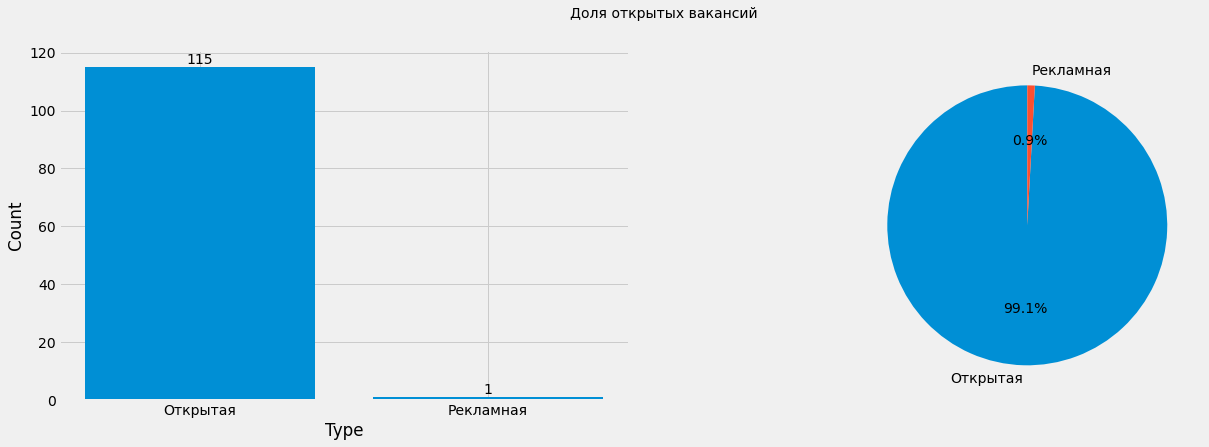

In [ ]:
# Открытые вакансии

df_tmp = df.groupby(['type']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Открытые вакансии', fontsize=14)


# в абсолютных величинах

axs[0].bar(x, y)
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Count')

rects = axs[0].patches
labels = df_tmp.to_list()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0].text(
        rect.get_x() + rect.get_width() / 2, height, 
        label, ha='center', va='bottom')
    

df_tmp = df.groupby(['type']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig.suptitle('Доля открытых вакансий', fontsize=14)

patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%', 
                                  textprops={'size': 'medium'}, startangle=90)
plt.show()

### Step 7.1 Кол-во вакансий с указанными контактами

In [ ]:
# Дальше работаем только с открытыми вакансиями

df = df[df['type'] == 'Открытая']

wo_contacts_cnt = len(df[df['contacts'].isna()].index)
w_contacts_cnt = len(df[df['contacts'].notna()].index)

print(f'Вакансий без контактов: {wo_contacts_cnt}')
print(f'Вакансий с контактами: {w_contacts_cnt}')

Вакансий без контактов: 115
Вакансий с контактами: 0


### Step 8. Вакансии в разрезе опыта

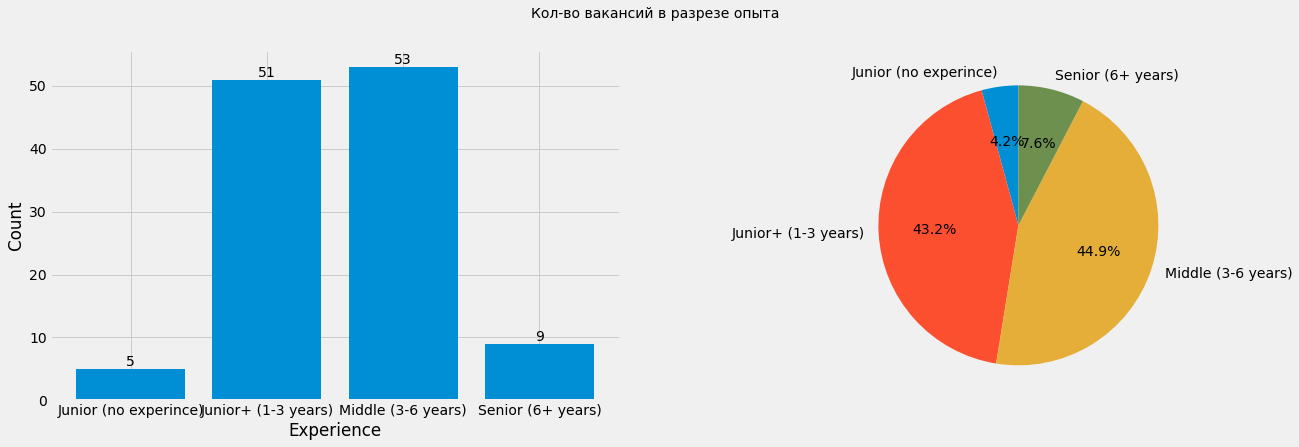

In [ ]:



# Кол-во вакансий в разрезе опыта (jun, jun+, mid, sen)

df_tmp = df.groupby(['experience']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Кол-во вакансий в разрезе опыта', fontsize=14)


# в абсолютных величинах

axs[0].bar(x, y)
axs[0].set_xlabel('Experience')
axs[0].set_ylabel('Count')

rects = axs[0].patches
labels = df_tmp.to_list()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0].text(
        rect.get_x() + rect.get_width() / 2, height, 
        label, ha='center', va='bottom')


# в относительных велечинах

patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%', 
                                  textprops={'size': 'medium'}, startangle=90)

### Step 9. TOP городов с вакансиями

Ниже в форме можно укзать любое необходимое кол-во городов

In [ ]:
cnt_cities = 5 #@param {type:"integer"}


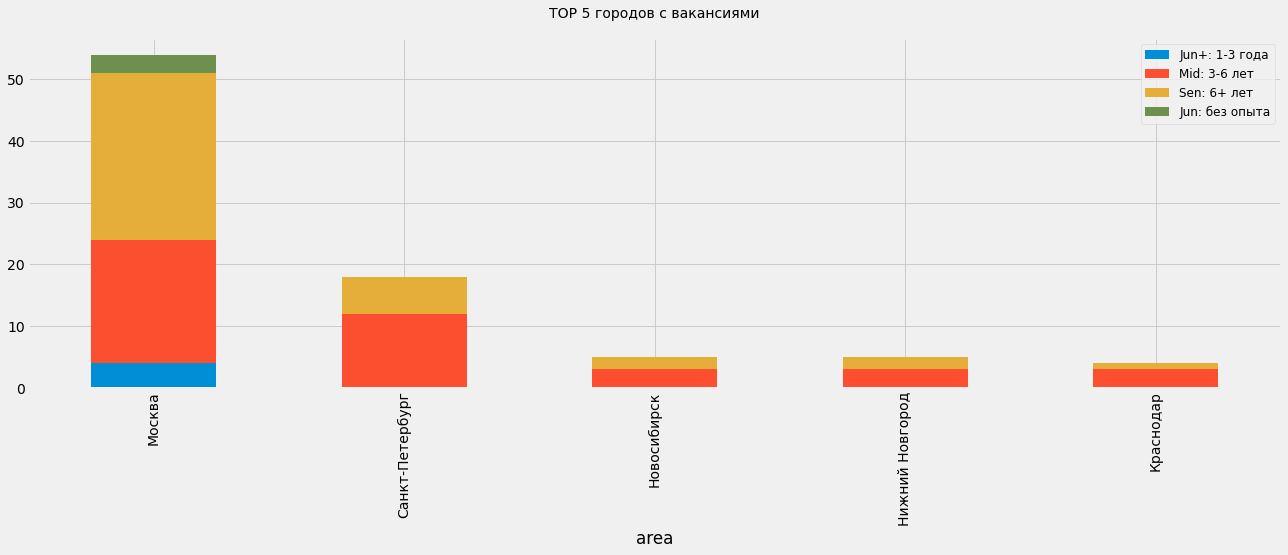

In [ ]:
# TOP городов с вакансиями

sorted_10 = df.groupby(['area']).size().sort_values(ascending=False)[:cnt_cities]
grouped = df[df['area'].isin(sorted_10.index.tolist())].groupby(['area', 'experience']).size()
grouped.reindex(index=sorted_10.index, level=0).unstack().plot(kind='bar', 
                                                               figsize=(20, 6), 
                                                               stacked=True)

plt.title(f'TOP {cnt_cities} городов с вакансиями', fontsize=14, pad=20)
plt.legend(['Jun+: 1-3 года', 'Mid: 3-6 лет', 'Sen: 6+ лет', 'Jun: без опыта'], fontsize=12)
plt.show()

### Step 10. Распределение скилов

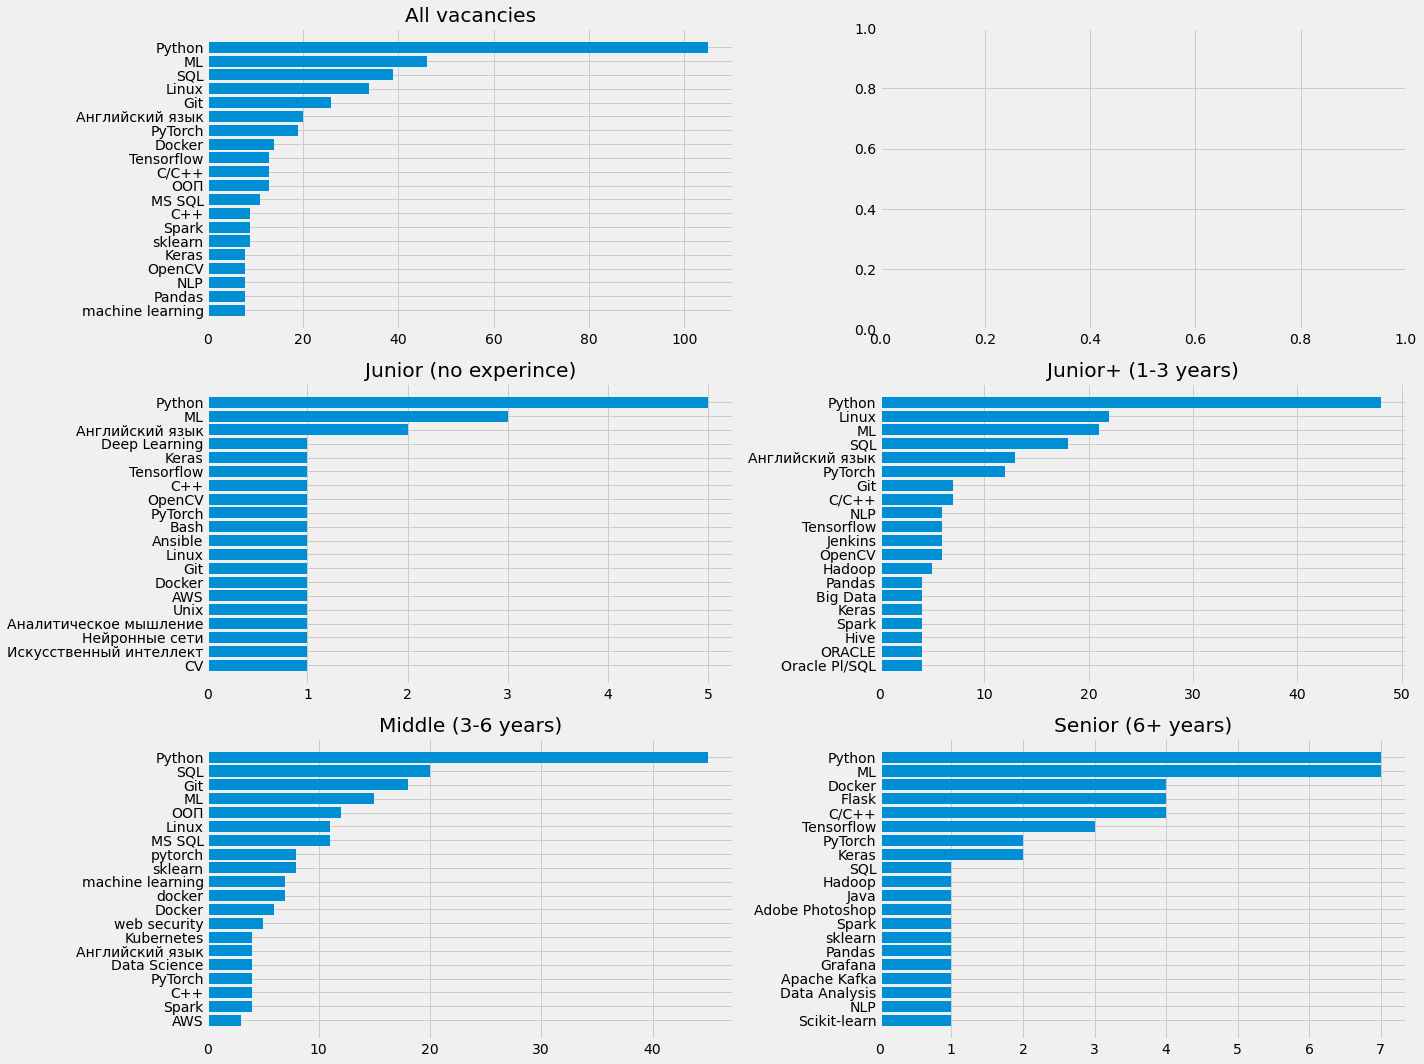

In [ ]:
# Распределение скиллов

def calculate_freq(df: pd.DataFrame, max_size=20) -> tuple:

    if len(df) == 0:
        return (0, 0)

    skills_dict = {}

    for row in df.iteritems():
        skills = row[1]
        for skill in skills:
            if skill in skills_dict:
                skills_dict[skill] += 1
            else:
                skills_dict[skill] = 1
    
    if len(skills_dict) < max_size:
        max_size = len(skills_dict)

    skills_dict = dict(sorted(skills_dict.items(), key=lambda item: item[1], 
                              reverse=True))
    
    return (list(skills_dict.keys())[:max_size][::-1], 
            list(skills_dict.values())[:max_size][::-1])
    
    
fig, axs = plt.subplots(3, 2, figsize=(20,15))

# все вакансии
x, y = calculate_freq(df['key_skills'])
axs[0, 0].barh(x, y)
axs[0, 0].set_title('All vacancies')

# junior (без опыта работы)
x, y = calculate_freq(df[df['experience'] == 'Junior (no experince)']['key_skills'])
axs[1, 0].barh(x, y)
axs[1, 0].set_title('Junior (no experince)')

# junior+
x, y = calculate_freq(df[df['experience'] == 'Junior+ (1-3 years)']['key_skills'])
axs[1, 1].barh(x, y)
axs[1, 1].set_title('Junior+ (1-3 years)')

# middle
x, y = calculate_freq(df[df['experience'] == 'Middle (3-6 years)']['key_skills'])
axs[2, 0].barh(x, y)
axs[2, 0].set_title('Middle (3-6 years)')

# senior
x, y = calculate_freq(df[df['experience'] == 'Senior (6+ years)']['key_skills'])
axs[2, 1].barh(x, y)
axs[2, 1].set_title('Senior (6+ years)')

fig.tight_layout()

### Step 11. TOP названий позиций

Нужно указать кол-во позиций в форме ниже

In [ ]:
cnt_titles = 10 #@param {type:"integer"}


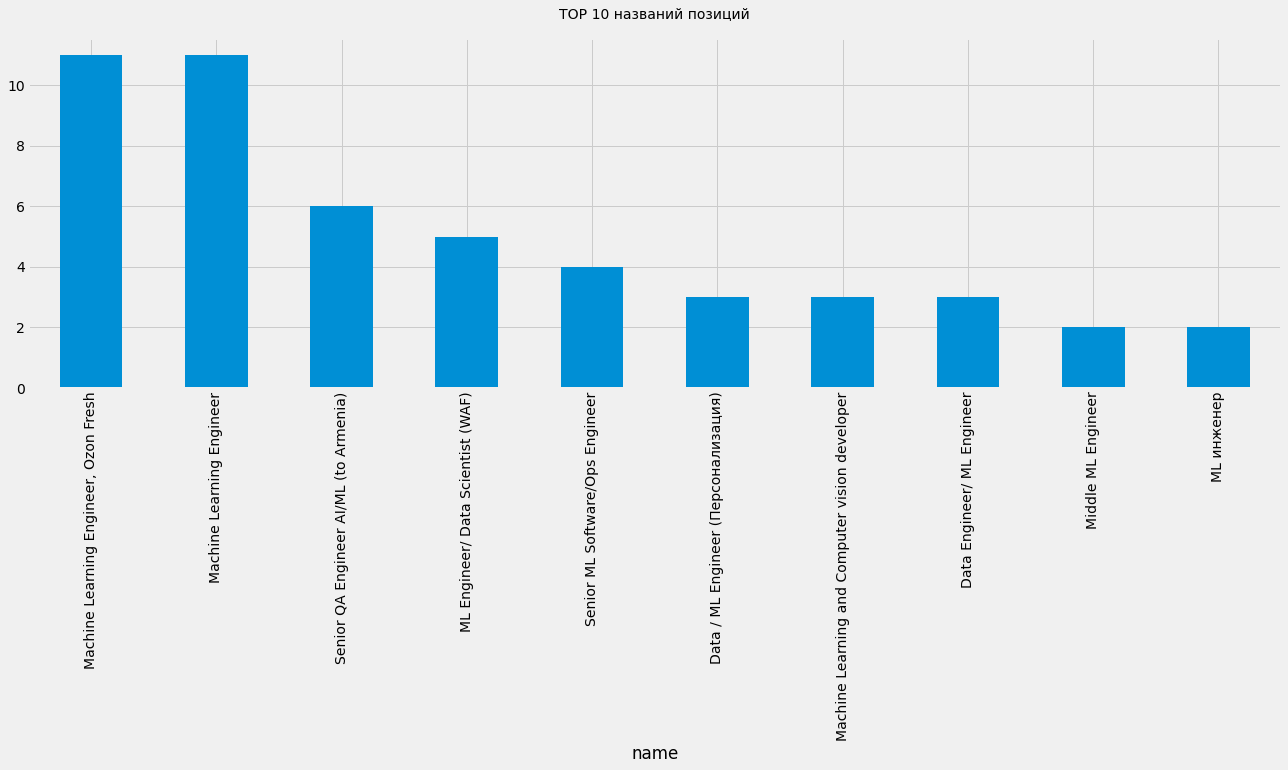

In [ ]:
# TOP названий позиций

x = df.groupby(['name']).size().sort_values(ascending=False)[:cnt_titles].plot(kind='bar', 
                                                                       figsize=(20, 6), 
                                                                       stacked=True)

plt.title(f'TOP {cnt_titles} названий позиций', fontsize=14, pad=20)
plt.show()

### Step 12. TOP нанимающих компаний

Нужно указать кол-во компаний в форме ниже

In [ ]:
cnt_comp =  5#@param {type:"integer"}


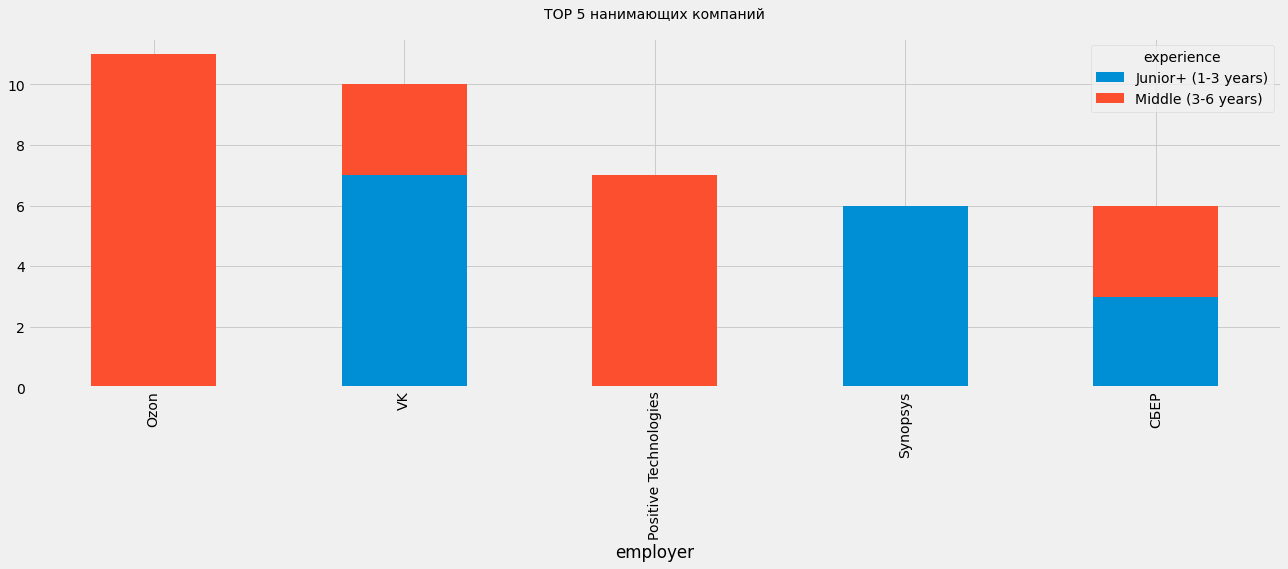

In [ ]:
# TOP нанимающих компаний

sorted_5 = df.groupby(['employer']).size().sort_values(ascending=False)[:cnt_comp]
grouped = df[df['employer'].isin(sorted_5.index.tolist())].groupby(['employer', 'experience']).size()
grouped.reindex(index=sorted_5.index, level=0).unstack().plot(kind='bar', 
                                                              figsize=(20, 6), 
                                                              stacked=True)

plt.title(f'TOP {cnt_comp} нанимающих компаний', fontsize=14, pad=20)
plt.show()

### Step 12.1 Удаленная работа / полный день

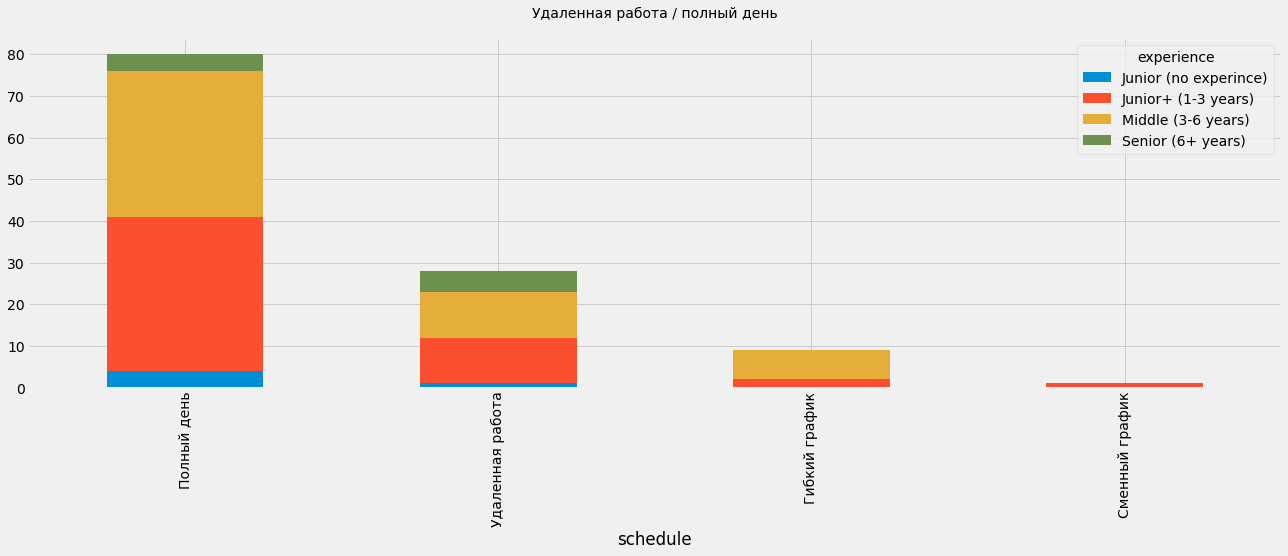

In [ ]:
sorted_5 = df.groupby(['schedule']).size().sort_values(ascending=False)
grouped = df[df['schedule'].isin(sorted_5.index.tolist())].groupby(['schedule', 'experience']).size()
grouped.reindex(index=sorted_5.index, level=0).unstack().plot(kind='bar', 
                                                              figsize=(20, 6), 
                                                              stacked=True)

plt.title(f'Удаленная работа / полный день', fontsize=14, pad=20)
plt.show()

### Step 12.2 Занятость

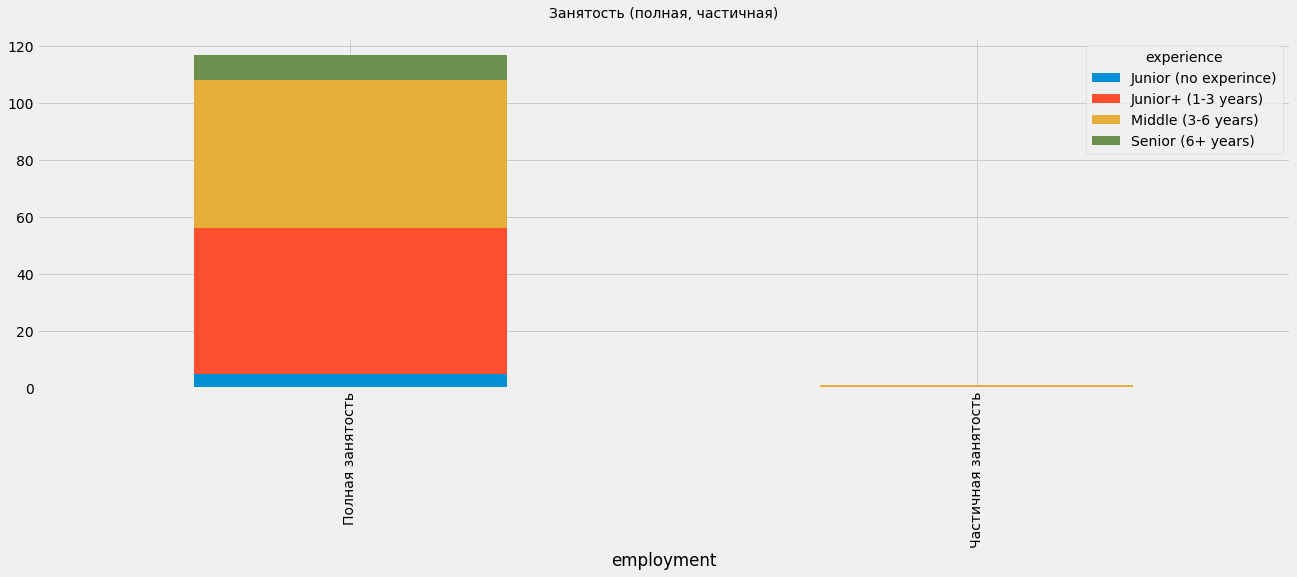

In [ ]:
sorted_5 = df.groupby(['employment']).size().sort_values(ascending=False)
grouped = df[df['employment'].isin(sorted_5.index.tolist())].groupby(['employment', 'experience']).size()
grouped.reindex(index=sorted_5.index, level=0).unstack().plot(kind='bar', 
                                                              figsize=(20, 6), 
                                                              stacked=True)

plt.title(f'Занятость (полная, частичная)', fontsize=14, pad=20)
plt.show()

### Step 13. Доля вакансий с указанной зарплатой

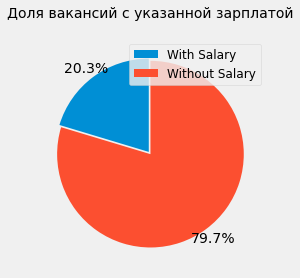

In [ ]:
# Доля вакансий с указанной зарплатой

df_with_salary = df[(~df['salary_from'].isnull()) | (~df['salary_to'].isnull())]
df_wo_salary = df[(df['salary_from'].isnull()) & (df['salary_to'].isnull())]

labels = ['With Salary', 'Without Salary']
patches, texts, pcts = plt.pie([len(df_with_salary.index), len(df_wo_salary.index)],
                               autopct='%.1f%%', textprops={'size': 'medium'}, 
                               startangle=90, pctdistance=1.12, explode=[0.03, 0])

plt.rcParams['figure.figsize'] = (20, 6)
plt.title('Доля вакансий с указанной зарплатой', fontsize=14, pad=20)
plt.legend(labels=labels, loc='upper right', fontsize=12)

plt.show()

### Step 14. Аналитика зарплат

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f579bb8be50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f579bb90f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f579bb9af50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f579bb9aa10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f579bb90490>,
  <matplotlib.lines.Line2D at 0x7f579bb4e7d0>]}

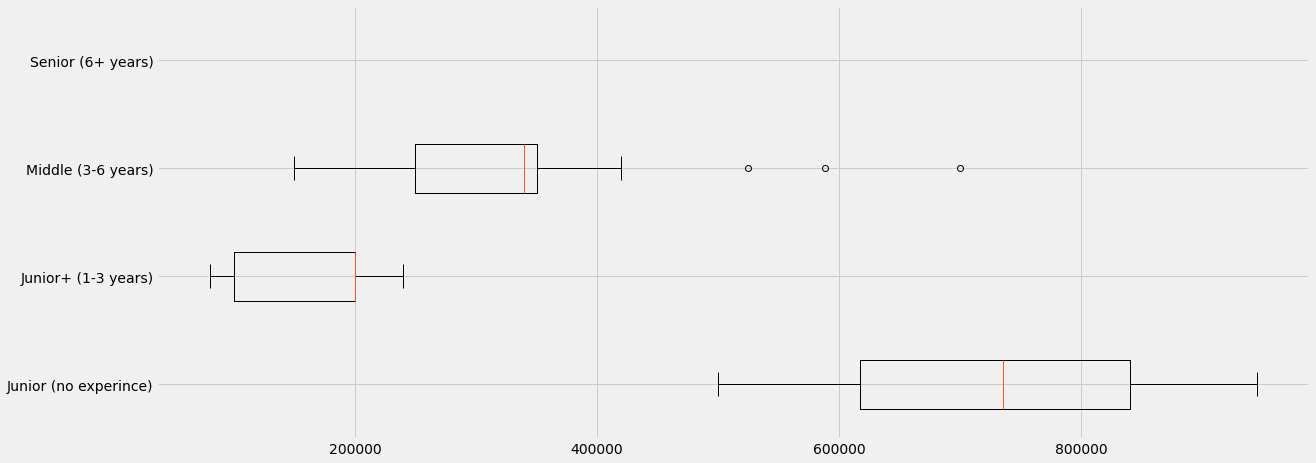

In [ ]:
# Аналитика зарплат

df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior (no experince)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
jun_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior+ (1-3 years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
jun_plus_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Middle (3-6 years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
middle_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Senior (6+ years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
senior_salary = s_tmp[~s_tmp.isnull()]


fig = plt.figure(figsize =(16, 6))
ax = fig.add_axes([0, 0, 1, 1])

labels = ['Junior (no experince)', 'Junior+ (1-3 years)',
          'Middle (3-6 years)', 'Senior (6+ years)']

ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary], 
           labels=labels, vert=False)

#### Как читать графики:
Все зарплаты указаны в рублях. Точками обозначены конкретные зарплаты. 

«Ящик с усами» 

Центральной вертикальной чертой (красной) показана медианная зарплата (половина зарплат ниже, а половина выше этой точки, можно считать эту зарплату средней), границы ящика — это 25 и 75 перцентили (делят нижнюю и верхнюю половину зарплат ещё раз пополам, в итоге половина всех зарплат лежат между ними). Усы ящика — это 10 и 90 перцентили (условно можно считать их минимальной и максимальной зарплатами).

Если остальись вопросы, можно почитать статью на habr: https://habr.com/ru/company/habr_career/blog/485146/

### Step 15. Таблица с аналитикой зарплат

In [ ]:
def get_summary_salary(dataset: pd.Series, exp: str) -> pd.DataFrame:
    
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    quartile_1 = np.round(dataset.quantile(0.25), 2)
    quartile_3 = np.round(dataset.quantile(0.75), 2)

    # Interquartile range
    iqr = np.round(quartile_3 - quartile_1, 2)
    
    details = {
        'Min': min_value,
        'Mean': mean,
        'Max': max_value,
        '25th percentile': quartile_1,
        'Median': median,
        '75th percentile': quartile_3,
        'Interquartile range (IQR)': iqr
    }

    return pd.DataFrame(details, index=[exp])


salaries = []

salaries.append(get_summary_salary(jun_salary, 'Junior (no experince)'))
salaries.append(get_summary_salary(jun_plus_salary, 'Junior+ (1-3 years)'))
salaries.append(get_summary_salary(middle_salary, 'Middle (3-6 years)'))
salaries.append(get_summary_salary(senior_salary, 'Senior (6+ years)'))

df_salaries = pd.concat(salaries)
df_salaries

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Min,Mean,Max,25th percentile,Median,75th percentile,Interquartile range (IQR)
Junior (no experince),500000.0,726666.67,945000.0,617500.0,735000.0,840000.0,222500.0
Junior+ (1-3 years),80000.0,170000.00,240000.0,100000.0,200000.0,200000.0,100000.0
Middle (3-6 years),150000.0,341084.37,700000.0,250000.0,340000.0,350801.5,100801.5
Senior (6+ years),NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 16. Сохраняем вакаансии в эксель в директорию на Google Drive

In [ ]:
df['published_at'] = df['published_at'].dt.tz_localize(None)
df.to_excel(f'{gdrive_path}/{position_title}.xlsx')